In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### Dataset: VHM Historical Data

In [2]:
data = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,68421.0,66541.0,68722.0,65789.0,1.05M,4.00%
2019-03-04,70075.0,69173.0,70300.0,67368.0,1.18M,2.42%
2019-03-05,68421.0,69323.0,69849.0,68045.0,1.50M,-2.36%
2019-03-06,69022.0,68421.0,69097.0,68270.0,770.13K,0.88%
2019-03-07,69173.0,69173.0,71654.0,69097.0,1.70M,0.22%
...,...,...,...,...,...,...
2024-05-27,39800.0,39850.0,40050.0,39750.0,4.62M,0.00%
2024-05-28,39950.0,39850.0,40050.0,39750.0,5.56M,0.38%
2024-05-29,39450.0,40000.0,40100.0,39450.0,8.03M,-1.25%


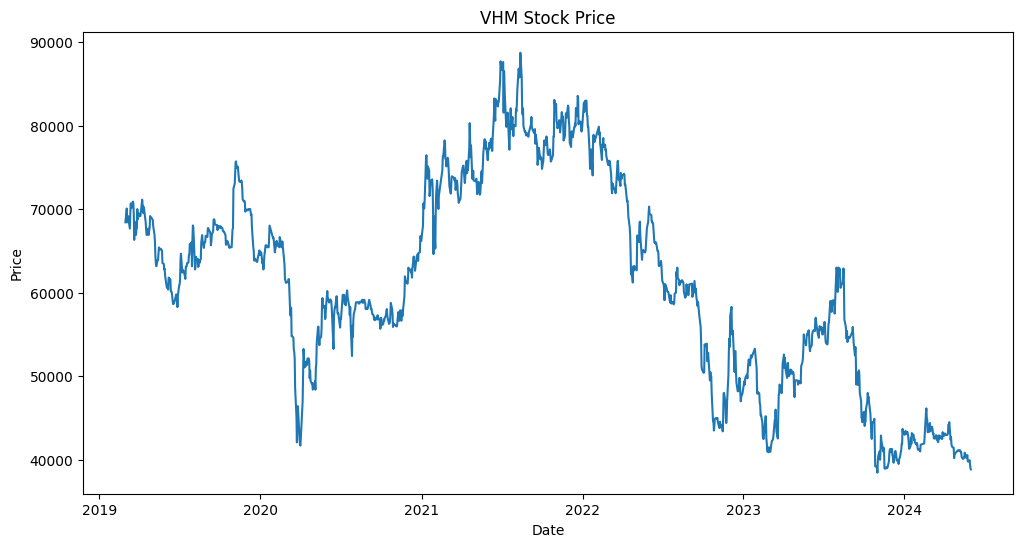

In [3]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price'])
plt.title('VHM Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [4]:
data = data.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
df = data['Price'].values.reshape(-1, 1)

#### Ratio 7:3

In [5]:
# Split data into train and test sets 
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [6]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [7]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [8]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=1, gamma=0.001, kernel='linear')

In [9]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [10]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 3.825592724934564
MAE: 1768.9043184071897
RMSE: 9526.764291524856


Forecast 30 days

In [11]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [12]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [13]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [14]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [15]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [16]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

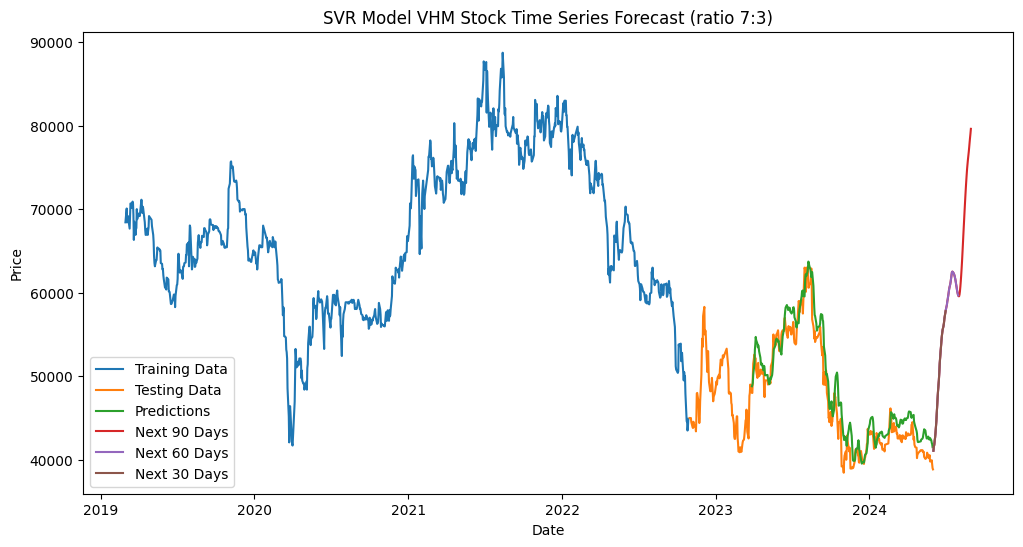

In [17]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model VHM Stock Time Series Forecast (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Ratio 8:2

In [18]:
# Split data into train and test sets 
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size+1]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [19]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [20]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [21]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=1000, gamma=0.001, kernel='sigmoid')

In [22]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [23]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 3.48616086367035
MAE: 1455.905096208913
RMSE: 3073.060888970167


Forecast 30 days

In [24]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [25]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [26]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [27]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [28]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [29]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

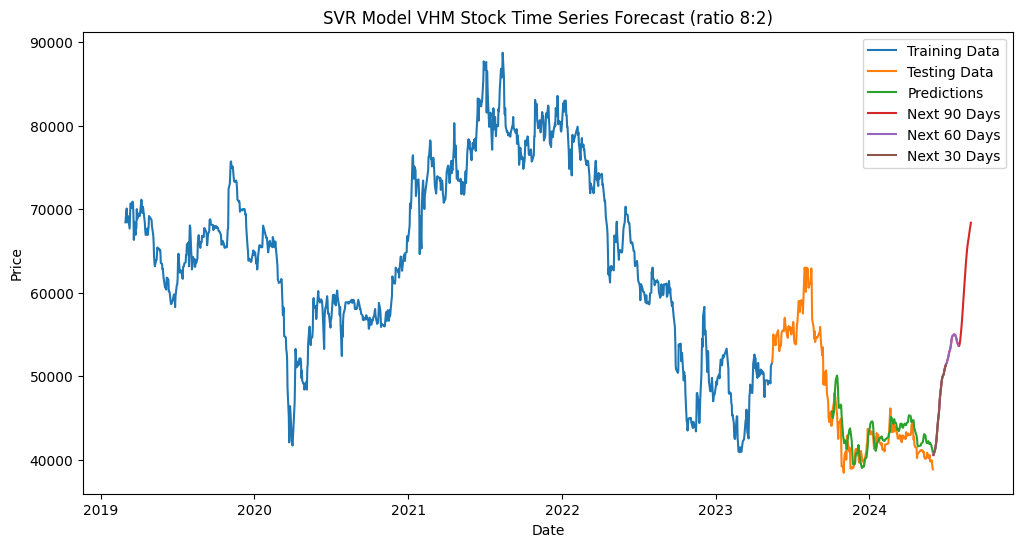

In [30]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size+1].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model VHM Stock Time Series Forecast (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Ratio 9:1

In [31]:
# Split data into train and test sets 
train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [32]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [33]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [34]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=1000, gamma=0.001, kernel='sigmoid')

In [35]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [36]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 1.7025503083894826
MAE: 690.9767393891917
RMSE: 1446.148060360978


Forecast 30 days

In [37]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [38]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [39]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [40]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [41]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [42]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

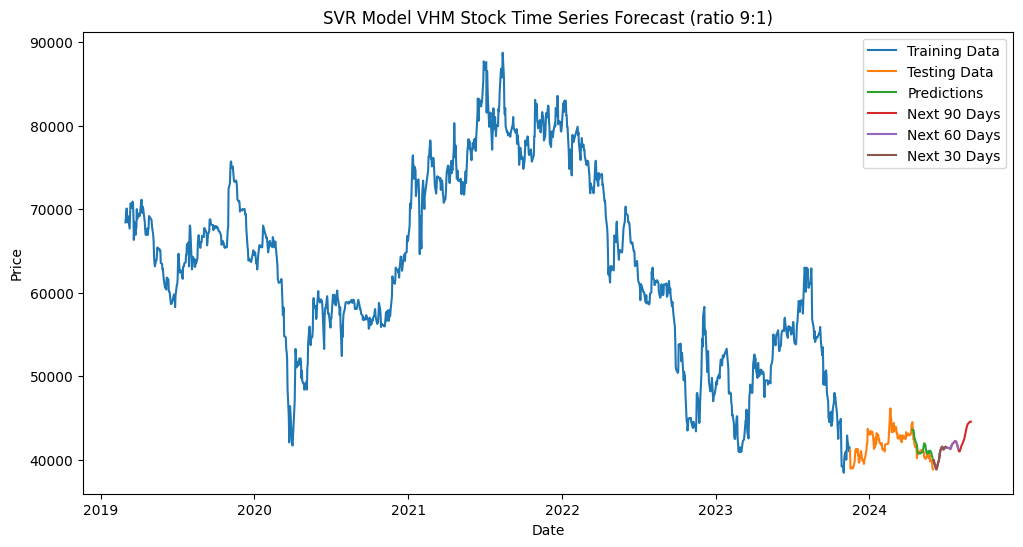

In [43]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model VHM Stock Time Series Forecast (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Dataset: NVL Historical Data

In [44]:
data = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,32933.0,31765.0,32933.0,31765.0,891.22K,2.95%
2019-03-04,33100.0,32933.0,33378.0,32600.0,899.13K,0.51%
2019-03-05,32711.0,32989.0,33211.0,32544.0,963.79K,-1.18%
2019-03-06,31709.0,32711.0,32711.0,31487.0,1.58M,-3.06%
2019-03-07,31932.0,31709.0,32210.0,31709.0,849.59K,0.70%
...,...,...,...,...,...,...
2024-05-27,14500.0,14600.0,14600.0,14300.0,7.87M,0.35%
2024-05-28,14500.0,14500.0,14600.0,14350.0,11.43M,0.00%
2024-05-29,14150.0,14550.0,14550.0,14150.0,15.86M,-2.41%


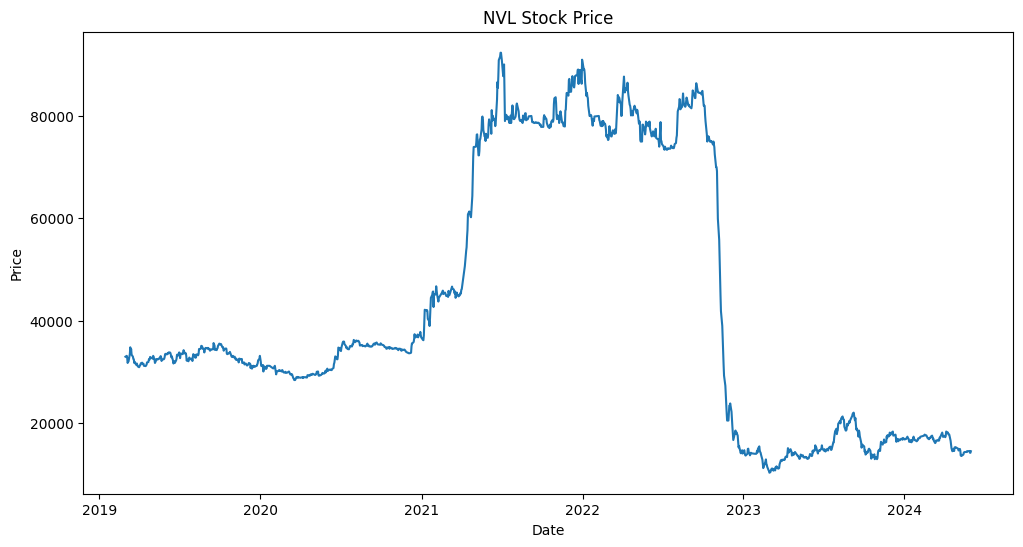

In [45]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price'])
plt.title('NVL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [46]:
data = data.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
df = data['Price'].values.reshape(-1, 1)

#### Ratio 7:3

In [47]:
# Split data into train and test sets 
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size+1]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [48]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [49]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [50]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=1000, gamma=0.001, kernel='sigmoid')

In [51]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [52]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 39.80127743999615
MAE: 6282.917566049438
RMSE: 7124.550798001382


Forecast 30 days

In [53]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [54]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [55]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [56]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [57]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [58]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

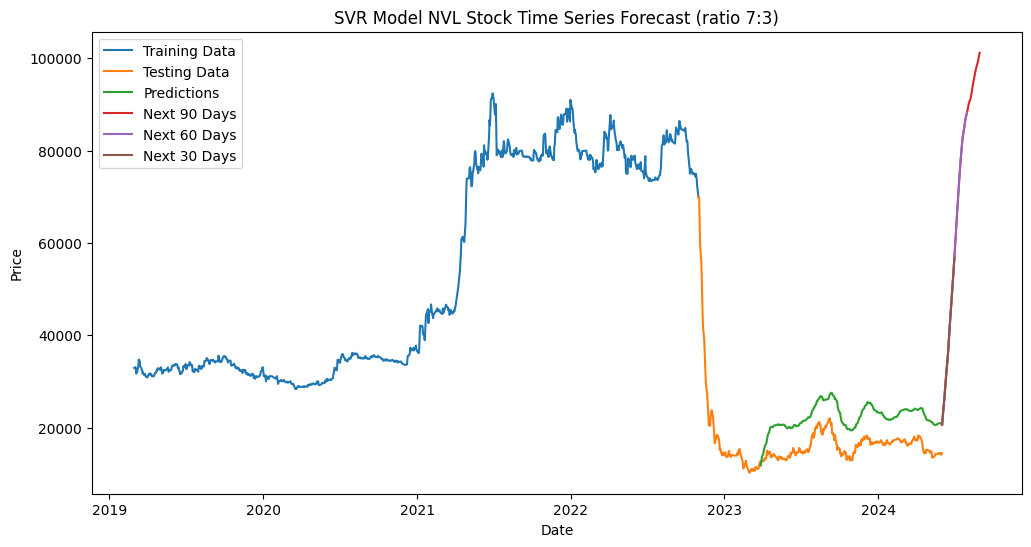

In [59]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size+1].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model NVL Stock Time Series Forecast (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Ratio 8:2

In [60]:
# Split data into train and test sets 
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [61]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [62]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [63]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=1000, gamma=0.001, kernel='sigmoid')

In [64]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [65]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 37.47073817263927
MAE: 5983.45793878703
RMSE: 6423.204881382905


Forecast 30 days

In [66]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [67]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [68]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [69]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [70]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [71]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

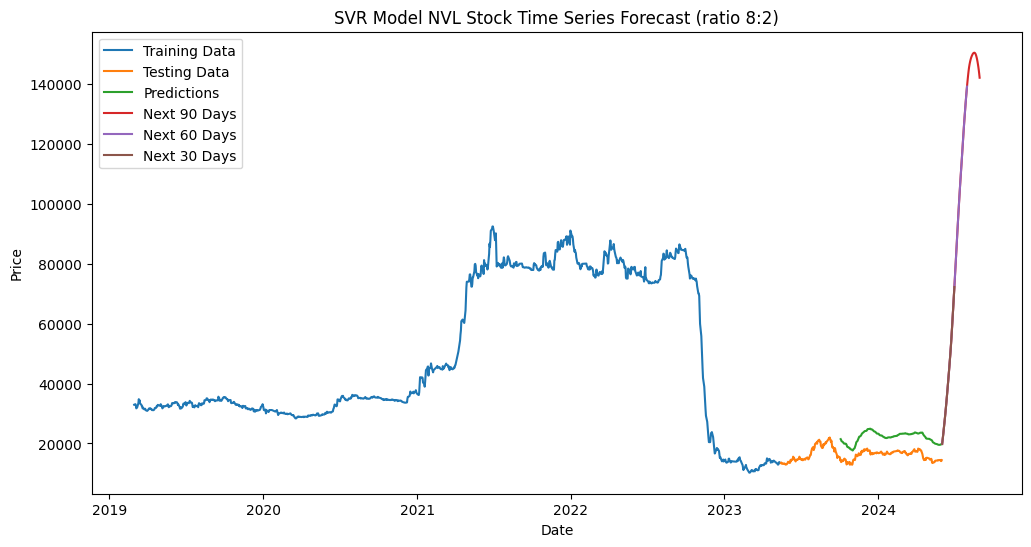

In [72]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model NVL Stock Time Series Forecast (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Ratio 9:1

In [73]:
# Split data into train and test sets 
train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [74]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [75]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [76]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=1, gamma=0.001, kernel='linear')

In [77]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [78]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 39.02267683701007
MAE: 5704.494436691856
RMSE: 5908.344156803955


Forecast 30 days

In [79]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [80]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [81]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [82]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [83]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [84]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

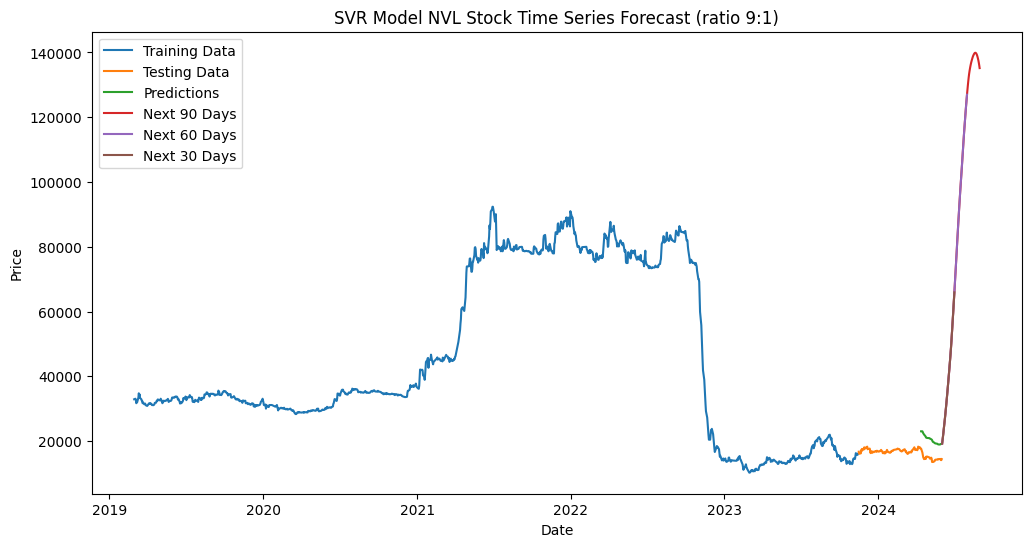

In [85]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model NVL Stock Time Series Forecast (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Dataset: NLG Historical Data

In [86]:
data = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')
data = data.sort_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)

data


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,18706.8,18496.6,18776.9,18496.6,365.80K,1.14%
2019-03-04,19127.2,18706.8,19127.2,18636.7,1.08M,2.25%
2019-03-05,18917.0,19127.2,19127.2,18846.9,468.76K,-1.10%
2019-03-06,18846.9,18987.1,19057.1,18811.9,225.18K,-0.37%
2019-03-07,18706.8,18846.9,18987.1,18671.8,453.92K,-0.74%
...,...,...,...,...,...,...
2024-05-27,43900.0,43900.0,44200.0,43000.0,1.56M,0.00%
2024-05-28,43701.0,43404.0,44047.0,43108.0,2.20M,-0.45%
2024-05-29,44400.0,43900.0,44600.0,43500.0,2.84M,1.60%


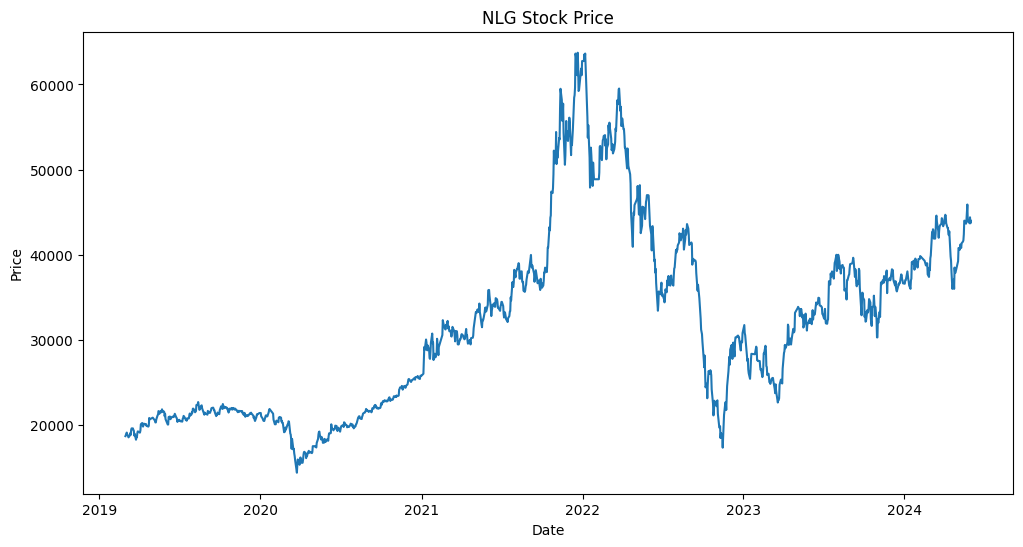

In [87]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price'])
plt.title('NLG Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [88]:
data = data.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
df = data['Price'].values.reshape(-1, 1)

#### Ratio 7:3

In [89]:
# Split data into train and test sets 
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size+1]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [90]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [91]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [92]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=1, gamma=0.001, kernel='linear')

In [93]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [94]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 3.9002952747378457
MAE: 1378.253073222702
RMSE: 5699.816847895844


Forecast 30 days

In [95]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [96]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [97]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [98]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [99]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [100]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

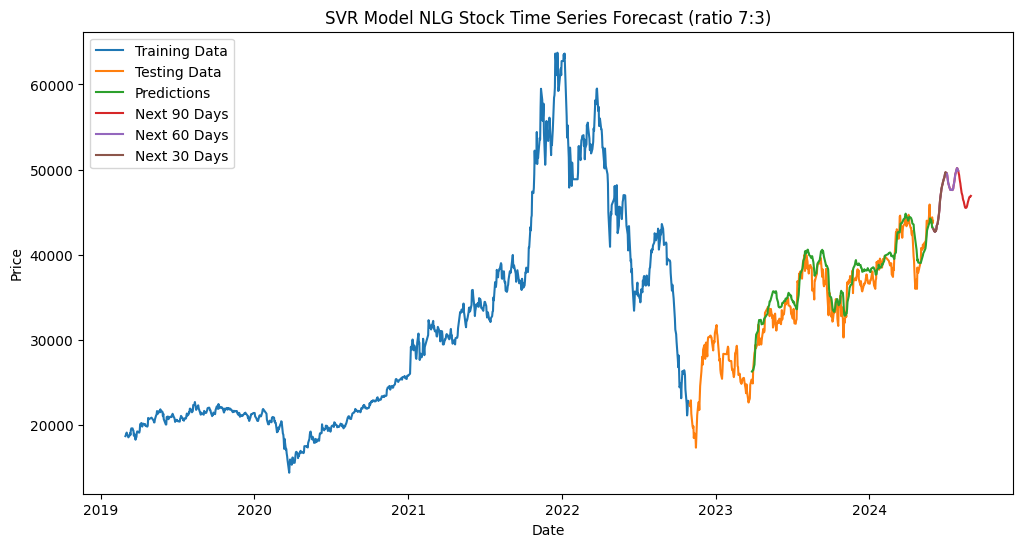

In [101]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size+1].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model NLG Stock Time Series Forecast (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Ratio 8:2

In [102]:
# Split data into train and test sets 
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size+1]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [103]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [104]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [105]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=0.1, gamma=0.001, kernel='linear')

In [106]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [107]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 3.111656684130949
MAE: 1160.36907820738
RMSE: 4839.673121766994


Forecast 30 days

In [108]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [109]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [110]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [111]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [112]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [113]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

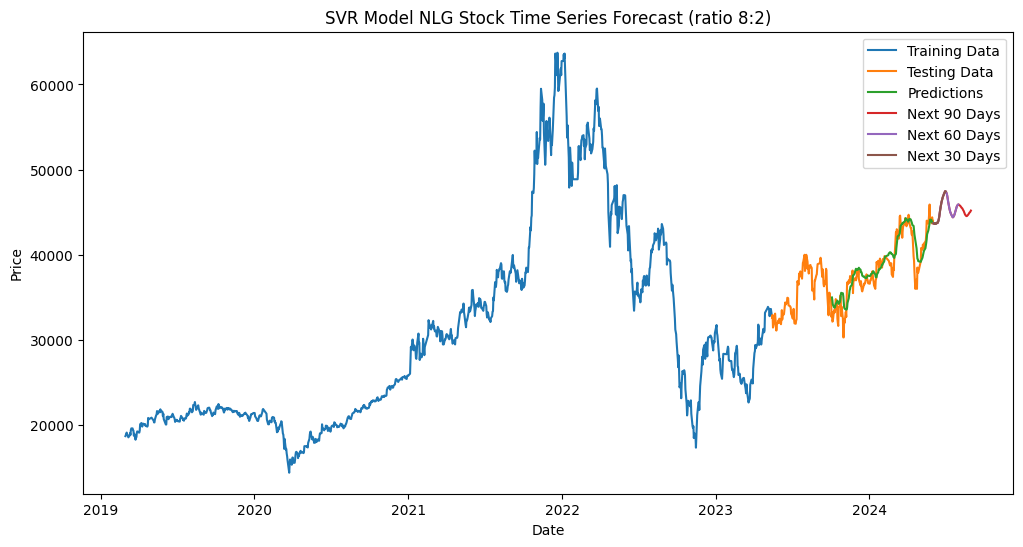

In [114]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size+1].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model NLG Stock Time Series Forecast (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Ratio 9:1

In [115]:
# Split data into train and test sets 
train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size+1]
test_data = df[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))


In [116]:
# Function to create datasets with lags
def create_dataset(dataset, lags=1):
    X, Y = [], []
    for i in range(len(dataset) - lags - 1):
        a = dataset[i:(i + lags), 0]
        X.append(a)
        Y.append(dataset[i + lags, 0])
    return np.array(X), np.array(Y)


lags = 100  # Choose the number of lagged time steps
X_train, Y_train = create_dataset(train_data, lags)
X_test, Y_test = create_dataset(test_data, lags)

In [117]:
C_range = [0.1, 1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5]
kernel = ['linear', 'poly', 'sigmoid']

param_grid = dict(C=C_range, gamma=gamma_range, epsilon=epsilon_range, kernel=kernel)

model = SVR()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#trong đó:
#param_grid: tham số
#verbose: hiển thị thông tin
#cv: số lượng folds cross-validation (chọn 5 folds cross-validation)
#scoring: đánh giá model bằng MSE


grid_result = grid.fit(X_train, Y_train)

In [118]:
# Set best parameters and fit the model
model.set_params(**grid_result.best_params_)
model.fit(X_train, Y_train)

SVR(C=1, gamma=0.001, kernel='linear')

In [119]:
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

In [120]:
# Calculate errors
mape = mean_absolute_percentage_error(Y_test_inv, y_pred_inv) * 100
mae = mean_absolute_error(Y_test_inv, y_pred_inv)
rmse = np.sqrt(np.mean((y_pred_inv - Y_test_inv)**2))

print('MAPE:', mape)
print('MAE:', mae)
print('RMSE:', rmse)

MAPE: 3.6835188185242083
MAE: 1452.457373656213
RMSE: 3301.064303672406


Forecast 30 days

In [121]:
# Crate index for the next 30 days
index_next_30_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=30)

# Predict the next 30 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_30_days = []
for i in range(30):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_30_days.append(yhat)  # add the prediction to the next_30_days

In [122]:
# Inverse transform the future predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1)).flatten()

Forecast 60 days

In [123]:
# Crate index for the next 60 days
index_next_60_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=60 )

# Predict the next 60 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_60_days = []
for i in range(60):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_60_days.append(yhat)  # add the prediction to the next_60_days

In [124]:
next_60_days = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1)).flatten()

Forecast 90 days

In [125]:
# Crate index for the next 60 days
index_next_90_days = pd.date_range(start=data.index[-1]+pd.Timedelta(days=1), periods=90 )

# Predict the next 90 days
x_input = test_data[-lags:].reshape(1, -1)  # get the last lags values from the test set
temp_input = x_input.flatten().tolist()  # convert to list

next_90_days = []
for i in range(90):
    x_input = np.array(temp_input[-lags:]).reshape(1, -1)  # get the last lags values from the temp_input and convert to array
    yhat = model.predict(x_input)[0]  # predict the next value
    # print(f"{i + 1} day input {x_input.flatten()}")
    # print(f"{i + 1} day output {yhat}")
    temp_input.append(yhat)  # add the prediction to the temp_input
    next_90_days.append(yhat)  # add the prediction to the next_90_days

In [126]:
next_90_days = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1)).flatten()

Visualize the forecast

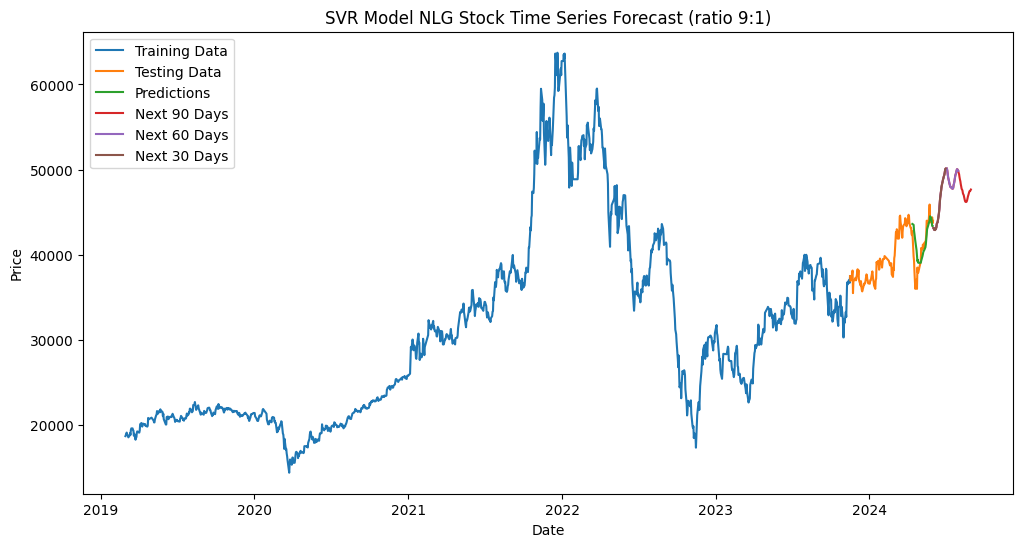

In [127]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data[:train_size+1].index,scaler.inverse_transform(train_data.reshape(-1, 1)), label='Training Data')
plt.plot(data[train_size:].index,scaler.inverse_transform(test_data.reshape(-1, 1)), label='Testing Data')
index_predict_start = train_size + lags
plt.plot(data.index[index_predict_start:index_predict_start + len(y_pred_inv)], y_pred_inv, label='Predictions')
plt.plot(index_next_90_days, next_90_days , label='Next 90 Days')
plt.plot(index_next_60_days, next_60_days , label='Next 60 Days')
plt.plot(index_next_30_days, next_30_days , label='Next 30 Days')


plt.title('SVR Model NLG Stock Time Series Forecast (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()